## Training and Evaluating the Model

### Imports

In [79]:
import pandas as pd
import numpy as np
import pickle
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
import matplotlib.pyplot as plt
import seaborn as sns

### Loading the Data

In [80]:
file_paths = ['2014-15.csv','2015-16.csv','2016-17.csv','2017-18.csv', '2018-19.csv', '2019-20.csv', '2020-21.csv', '2021-22.csv', '2022-23.csv', '2023-24.csv']
dfs = [pd.read_csv('../data/'+ file, index_col=0) for file in file_paths]
df = pd.concat(dfs, ignore_index=False)
df.head()

,Wk,Day,Date,Time,Home,Score,Away,Attendance,Venue,Referee,Match Report,Notes,xG,xG.1
0,1.0,Sat,2014-08-16,12:45,Manchester Utd,1–2,Swansea City,75339.0,Old Trafford,Mike Dean,Match Report,NaN,NaN,NaN
1,1.0,Sat,2014-08-16,15:00,Stoke City,0–1,Aston Villa,27478.0,Bet365 Stadium,Anthony Taylor,Match Report,NaN,NaN,NaN
2,1.0,Sat,2014-08-16,15:00,Leicester City,2–2,Everton,31603.0,King Power Stadium,Mike Dean,Match Report,NaN,NaN,NaN
3,1.0,Sat,2014-08-16,15:00,QPR,0–1,Hull City,17603.0,Loftus Road Stadium,Craig Pawson,Match Report,NaN,NaN,NaN
4,1.0,Sat,2014-08-16,15:00,West Ham,0–1,Tottenham,34977.0,Boleyn Ground,Chris Foy,Match Report,NaN,NaN,NaN


### Data Cleaning

In [81]:
df.drop(columns=['Notes', 'Match Report', 'xG', 'xG.1', 'Attendance'], inplace=True)
df.rename(columns={'Home':'HomeTeam', 'Away': 'AwayTeam'}, inplace=True)
df.dropna(subset=['Day'], inplace=True) # Dropping any NaN rows in the data

df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")
df['Wk'] = df['Wk'].astype(int)
 
# print(df.info()) # Checking if there are empty rows

### Adding Features
df[['FTHG', 'FTAG']] = df['Score'].str.split('–', expand=True).astype(int)  # Full-Time Home Goals and Full-Time Away Goals
conditions = [df['FTHG'] > df['FTAG'], df['FTHG'] < df['FTAG']]
df['Result'] = np.select(conditions, choicelist=['W', 'L'], default='D')

# Calculate the season year based on the start month
season_start_month = 8  # # Define the start month of the season: August
df['Season'] = df['Date'].apply(lambda x: x.year if x.month >= season_start_month else x.year - 1)

# Convert the season year to a format like '2023/24'
df['Season'] = df['Season'].astype(str) + '/' + (df['Season'] + 1).astype(str).str[2:]

df.head()

,Wk,Day,Date,Time,HomeTeam,Score,AwayTeam,Venue,Referee,FTHG,FTAG,Result,Season
0,1,Sat,2014-08-16,12:45,Manchester Utd,1–2,Swansea City,Old Trafford,Mike Dean,1,2,L,2014/15
1,1,Sat,2014-08-16,15:00,Stoke City,0–1,Aston Villa,Bet365 Stadium,Anthony Taylor,0,1,L,2014/15
2,1,Sat,2014-08-16,15:00,Leicester City,2–2,Everton,King Power Stadium,Mike Dean,2,2,D,2014/15
3,1,Sat,2014-08-16,15:00,QPR,0–1,Hull City,Loftus Road Stadium,Craig Pawson,0,1,L,2014/15
4,1,Sat,2014-08-16,15:00,West Ham,0–1,Tottenham,Boleyn Ground,Chris Foy,0,1,L,2014/15


### Encoding

In [ ]:
# Encoding Teams
all_teams = pd.concat([df['HomeTeam'],df['AwayTeam']]).unique()
all_teams = np.append(all_teams, 'Ipswich Town') # Adding team since it was promoted
# print(f"The teams: \n {all_teams} \n") # Checking all teams are unique

encoder = LabelEncoder()
encoder.fit(all_teams)

df['HomeTeamEncoded'] = encoder.transform(df['HomeTeam'])
df['AwayTeamEncoded'] = encoder.transform(df['AwayTeam'])

# Save the encoder
with open('../encoders/team_encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)

# Encoding Venue
venue_encoder = LabelEncoder()
venues = df['Venue'].unique()
venues = np.append(venues, 'Portman Road Stadium') # Adding new stadiums
# print(f"The stadiums: \n {venues}")

venue_encoder.fit(venues)
df['venue_code'] = venue_encoder.transform(df['Venue'])

# Save the encoder
with open('../encoders/venue_encoder.pkl', 'wb') as file:
    pickle.dump(venue_encoder, file)

# Encoding day and hour
df["hour"] = df["Time"].str.replace(":+", "", regex=True).astype("int")  # Time that matches play may be a factor - regex to reformat from "hh:mm" to "hh"
df["day_code"] = df["Date"].dt.dayofweek # Gives each day of the week a code e.g. Mon = 0, Tues = 2, ....
df['season_encoded'] = df['Season'].rank(method='dense').astype(int)
len(all_teams), len(venues)

df.head()

,Wk,Day,Date,Time,HomeTeam,Score,AwayTeam,Venue,Referee,FTHG,FTAG,Result,Season,HomeTeamEncoded,AwayTeamEncoded,venue_code,hour,day_code,season_encoded
0,1,Sat,2014-08-16,12:45,Manchester Utd,1–2,Swansea City,Old Trafford,Mike Dean,1,2,L,2014/15,19,29,20,1245,5,1
1,1,Sat,2014-08-16,15:00,Stoke City,0–1,Aston Villa,Bet365 Stadium,Anthony Taylor,0,1,L,2014/15,27,1,1,1500,5,1
2,1,Sat,2014-08-16,15:00,Leicester City,2–2,Everton,King Power Stadium,Mike Dean,2,2,D,2014/15,15,9,14,1500,5,1
3,1,Sat,2014-08-16,15:00,QPR,0–1,Hull City,Loftus Road Stadium,Craig Pawson,0,1,L,2014/15,24,12,17,1500,5,1
4,1,Sat,2014-08-16,15:00,West Ham,0–1,Tottenham,Boleyn Ground,Chris Foy,0,1,L,2014/15,33,30,2,1500,5,1


### Rolling Avg Shooting Stats

In [ ]:
teams = json.load(open('../encoders/training_teams.json')) # Doesn't contain Ipswich Town

def rolling_stats(df, team_name):
    df.dropna(subset=['Date'], inplace=True) 

    # Getting rolling averages
    cols = ["GF", "GA", "Sh", "SoT", "PK","PKatt"]
    new_cols = [f"{c}_rolling" for c in cols]
    rolling_stats = df[cols].rolling(3, closed='left').mean()
    df[new_cols] = rolling_stats
    # df = df.dropna(subset=new_cols)

    df.loc[df['Venue'] == 'Home', 'HomeTeam'] = team_name
    df.loc[df['Venue'] == 'Home', 'AwayTeam'] = df['Opponent']
    df.loc[df['Venue'] == 'Away', 'HomeTeam'] = df['Opponent']
    df.loc[df['Venue'] == 'Away', 'AwayTeam'] = team_name
    df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")
    
    # Check if 'Venue' column has correct entries
    if 'Home' not in df['Venue'].unique() or 'Away' not in df['Venue'].unique():
        print("Error: 'Venue' column does not contain expected values.")
        return df
    
    rolling_home_cols = [f"{c}_rolling_h" for c in cols]
    rolling_away_cols = [f"{c}_rolling_a" for c in cols]

    df.loc[df['Venue'] == 'Home', rolling_home_cols] = df.loc[df['Venue'] == 'Home', new_cols].values
    df.loc[df['Venue'] == 'Away', rolling_away_cols] = df.loc[df['Venue'] == 'Away', new_cols].values

    # Filling in missing rolling away stats with 0 so that they don't add an bias to the stats - form at start of season is unknown
    # First week rolling shooting stats are set at 0 so so that they don't add an bias to the stats - form at start of season is unknown
    if 'Round' in df.columns and df['Round'].dtype == 'object':
        # Extract the numeric part from 'Round' and convert it to an integer
        df['Wk'] = df['Round'].str.extract(r'(\d+)').astype(int)
    else:
        print("Error: 'Round' column is missing or not in the expected format.")

    # Week 1
    df.loc[(df['Wk']==1) & (df['Venue'] == 'Home'), rolling_home_cols] = 0
    df.loc[(df['Wk']==1) & (df['Venue'] == 'Away'), rolling_away_cols] = 0

    # Week 2 - set at the last week's stats
    df.loc[(df['Wk']==2) & (df['Venue'] == 'Home'), rolling_home_cols] = 0
    df.loc[(df['Wk']==2) & (df['Venue'] == 'Away'), rolling_away_cols] = 0
   
    # Week 3
    df.loc[(df['Wk']==3) & (df['Venue'] == 'Home'), rolling_home_cols] = 0
    df.loc[(df['Wk']==3) & (df['Venue'] == 'Away'), rolling_away_cols] = 0

    return df

def merge_rolling_stats(teams):
    rolling_dfs = []

    for team in teams:
        df = pd.read_csv('../data/shooting_data/'+ team + '.csv')
        rolling_df = rolling_stats(df, teams[team])
        rolling_dfs.append(rolling_df)
    
    combined_df = pd.concat(rolling_dfs, ignore_index=False)
    merged_df = combined_df.groupby(['Date', 'HomeTeam', 'AwayTeam'], as_index=False).first()
    merged_df = merged_df.drop(['G-xG', 'npxG', 'npxG/Sh', 'np:G-xG', 'xG', 'Match Report', 'Match Report.1'], axis=1)

    return merged_df

rolling_df = merge_rolling_stats(teams)
result = pd.merge(df, rolling_df, how="left", on=["Day","Date", "Time", "HomeTeam", "AwayTeam"], suffixes=('','_y') )

df = result
columns_with_nan = df.columns[df.isna().any()].tolist()
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: ['Dist', 'FK', 'GF_rolling', 'GA_rolling', 'Sh_rolling', 'SoT_rolling', 'PK_rolling', 'PKatt_rolling', 'GF_rolling_h', 'GA_rolling_h', 'Sh_rolling_h', 'SoT_rolling_h', 'PK_rolling_h', 'PKatt_rolling_h']


### Calculating current form with a rolling Points Per Game (PPG) of past 3 games

In [84]:
def calculate_points(row):
    """Function to calculate points for each team in each game"""
    if row['FTHG'] > row['FTAG']:  # Home team wins
        row['HomePoints'] = 3
        row['AwayPoints'] = 0
    elif row['FTHG'] < row['FTAG']:  # Away team wins
        row['HomePoints'] = 0
        row['AwayPoints'] = 3
    else:  # Draw
        row['HomePoints'] = 1
        row['AwayPoints'] = 1
    return row

df = df.apply(calculate_points, axis=1) # Apply the points calculation to each row

for team in teams.values():
    # Get all the matches of a team
    # Calculate the rolling points per game with a window of 3 games
    team_df = df[(df['HomeTeam'] == team)|(df['AwayTeam'] == team)].copy()
    team_df['Points'] = team_df['HomePoints'].where(team_df['HomeTeam'] == team, team_df['AwayPoints'])
    team_df['PPG_rolling'] = team_df['Points'].rolling(3, closed='left').mean().fillna(0)
    
    team_df.loc[:, 'Points'] = df['HomePoints'].where(df['HomeTeam'] == team, df['AwayPoints'])
    df.loc[df['HomeTeam'] == team, 'PPG_rolling_h'] = team_df.loc[team_df['HomeTeam'] == team, 'PPG_rolling']
    df.loc[df['AwayTeam'] == team, 'PPG_rolling_a'] = team_df.loc[team_df['AwayTeam'] == team, 'PPG_rolling']


## Features and Labels

In [ ]:
# Features and labels
cols = ["GF", "GA", "Sh", "SoT", "PK","PKatt"]
rolling_home_cols = [f"{c}_rolling_h" for c in cols]
rolling_away_cols = [f"{c}_rolling_a" for c in cols]

features = ['HomeTeamEncoded', 'AwayTeamEncoded', 'Wk', 'hour', 'day_code', 'venue_code', 'season_encoded', 'PPG_rolling_h', 'PPG_rolling_a']
features.extend(rolling_home_cols)
features.extend(rolling_away_cols)
print(f"Features are \n {features}")

labels = ['FTHG', 'FTAG']
X = df[features]
y = df[labels]  # Predicting home and away goals

X.loc[X.isna().any(axis=1),rolling_home_cols] = 0 # Luton Town had their third game in Week 4 of 2023-24 season

from sklearn.preprocessing import StandardScaler
# Scale your features
scaler = StandardScaler()
X = scaler.fit_transform(X)


Features are 
 ['HomeTeamEncoded', 'AwayTeamEncoded', 'Wk', 'hour', 'day_code', 'venue_code', 'season_encoded', 'PPG_rolling_h', 'PPG_rolling_a', 'GF_rolling_h', 'GA_rolling_h', 'Sh_rolling_h', 'SoT_rolling_h', 'PK_rolling_h', 'PKatt_rolling_h', 'GF_rolling_a', 'GA_rolling_a', 'Sh_rolling_a', 'SoT_rolling_a', 'PK_rolling_a', 'PKatt_rolling_a']


### Training Split

In [86]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Selection and Evaluation

In [87]:
def evaluate_model(model, X_train, X_test, y_train, y_test, target_names = ['FTHG', 'FTAG']):
    """
    Evaluate a multi-output regression model and visualize its performance.

    Parameters:
    - model: The regression model to evaluate.
    - X_train: Training feature data.
    - X_test: Test feature data.
    - y_train: Training target data (multi-output).
    - y_test: Test target data (multi-output).
    - target_names: List of target variable names (e.g., ['FTHG', 'FTAG']).

    Returns:
    - Metrics: Dictionary containing MAE, MSE, RMSE, R2 for each target.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    metrics = {}
    metrics['MAE'] = mean_absolute_error(y_test, y_pred, multioutput='uniform_average')
    metrics['R2'] = r2_score(y_test, y_pred, multioutput='uniform_average')

    print("Mean Absolute Error (MAE):", metrics['MAE'])
    print("R-squared (R2):", metrics['R2'])

    # Visualization
    plt.figure(figsize=(8, 4))

    for i, target_name in enumerate(target_names):
        plt.subplot(1, len(target_names), i + 1)
        plt.scatter(y_test[target_name], y_pred[:, i], color='blue', label='Predicted')
        plt.xlabel(f'Actual {target_name}')
        plt.ylabel(f'Predicted {target_name}')
        plt.title(f'Actual vs. Predicted {target_name}')
        plt.plot([y_test[target_name].min(), y_test[target_name].max()],
                 [y_test[target_name].min(), y_test[target_name].max()], color='red', linestyle='--')
        plt.legend()

    plt.tight_layout()
    plt.show()

    return metrics

### Non-classification models

The models considered were Linear Regression, Random Forest Regressor, Gradient Boosting Machines, and Support Vector Machines. However since we are predicting discrete values (FTHG and FTAG), a model which predicts discrete values would fit this problem better.

In [88]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

def evaluate_model_performance(y_true, y_pred):
    """
    Evaluates model performance on football score predictions with multiple metrics.
    """
    y_true = y_true.reset_index(drop=True)
    y_pred = y_pred.reset_index(drop=True)
    
    # Calculate Mean Absolute Error for FTHG and FTAG
    mae_home = mean_absolute_error(y_true['FTHG'], y_pred['FTHG'])  # FTHG
    mae_away = mean_absolute_error(y_true['FTAG'], y_pred['FTAG'])  # FTAG

    r2_home = r2_score(y_true['FTHG'], y_pred['FTHG'])
    r2_away = r2_score(y_true['FTAG'], y_pred['FTAG'])

    # Calculate Root Mean Squared Error for FTHG and FTAG
    rmse_home = root_mean_squared_error(y_true['FTHG'], y_pred['FTHG'])
    rmse_away = root_mean_squared_error(y_true['FTAG'], y_pred['FTAG'])
    
    # Calculate Total Mean Absolute Error and RMSE
    mae_total = (mae_home + mae_away) / 2
    rmse_total = (rmse_home + rmse_away) / 2
    
    # Exact Match Ratio (how often both FTHG and FTAG are predicted exactly)
    exact_matches = np.sum((y_true['FTHG'] == y_pred['FTHG']) & (y_true['FTAG'] == y_pred['FTAG']))
    exact_match_percentage = 100 * exact_matches / len(y_true)
    

    # Goal Difference Prediction Accuracy
    goal_diff_true = y_true['FTHG'] - y_true['FTAG']
    goal_diff_pred = y_pred['FTHG'] - y_pred['FTAG']
    goal_diff_accuracy = np.mean(np.sign(goal_diff_true) == np.sign(goal_diff_pred))
    
    true_result = np.select([y_true['FTHG'] > y_true['FTAG'], y_true['FTHG'] < y_true['FTAG']], choicelist=['W', 'L'], default='D')
    pred_result = np.select([y_pred['FTHG'] > y_pred['FTAG'], y_pred['FTHG'] < y_pred['FTAG']], choicelist=['W', 'L'], default='D')
    
    correct_results = np.sum(pred_result == true_result)
    correct_results_percentage = 100 * correct_results / pred_result.shape[0]
    results = {
        'MAE_Home': mae_home,'MAE_Away': mae_away,'MAE_Total': mae_total, 
        'RMSE_Home': rmse_home,'RMSE_Away': rmse_away,'RMSE_Total': rmse_total,
        'R2_Home': r2_home,'R2_Away': r2_away,
        'Correct_Results': correct_results, 'Correct_Result_%': correct_results_percentage,
        'Exact_Matches': exact_matches,'Exact_Match_%': exact_match_percentage,'Goal_Difference_Accuracy': goal_diff_accuracy
    }
    
    return results

#### Linear Regression Model

In [78]:
# Fit two separate models, one for FTHG and one for FTAG
model_home = LinearRegression()
model_away = LinearRegression()
model_home.fit(X_train, y_train['FTHG'])
model_away.fit(X_train, y_train['FTAG'])

y_pred_home = np.round(model_home.predict(X_test)).astype(int)
y_pred_away = np.round(model_away.predict(X_test)).astype(int)

y_pred = pd.DataFrame({'FTHG': y_pred_home, 'FTAG': y_pred_away})
evaluate_model_performance(y_test, y_pred)

{'MAE_Home': 1.006578947368421,
 'MAE_Away': 0.8907894736842106,
 'MAE_Total': 0.9486842105263158,
 'RMSE_Home': 1.3113873730157932,
 'RMSE_Away': 1.2036129820363004,
 'RMSE_Total': 1.2575001775260468,
 'R2_Home': 0.017292260874812948,
 'R2_Away': 0.014230024775016226,
 'Correct_Results': 343,
 'Correct_Result_%': 45.13157894736842,
 'Exact_Matches': 68,
 'Exact_Match_%': 8.947368421052632,
 'Goal_Difference_Accuracy': 0.4513157894736842}

#### Gradient Boosting Machines (GBM)

Gradient Boosting Machines, such as GradientBoostingRegressor from scikit-learn or more advanced libraries like XGBoost or LightGBM, can often provide better predictive performance than linear models and random forests, especially on complex datasets.

In [94]:
# Fit two separate models, one for FTHG and one for FTAG
model_home = GradientBoostingRegressor(n_estimators=300, random_state=42)
model_away = GradientBoostingRegressor(n_estimators=300, random_state=42)
model_home.fit(X_train, y_train['FTHG'])
model_away.fit(X_train, y_train['FTAG'])

y_pred_home = np.round(model_home.predict(X_test)).astype(int)
y_pred_away = np.round(model_away.predict(X_test)).astype(int)

y_pred = pd.DataFrame({'FTHG': y_pred_home, 'FTAG': y_pred_away})
evaluate_model_performance(y_test, y_pred)

{'MAE_Home': 0.9802631578947368,
 'MAE_Away': 0.9236842105263158,
 'MAE_Total': 0.9519736842105263,
 'RMSE_Home': 1.2982782120136938,
 'RMSE_Away': 1.2172012764405158,
 'RMSE_Total': 1.2577397442271048,
 'R2_Home': 0.036841152395283294,
 'R2_Away': -0.008153489648802692,
 'Correct_Results': 354,
 'Correct_Result_%': 46.578947368421055,
 'Exact_Matches': 73,
 'Exact_Match_%': 9.605263157894736,
 'Goal_Difference_Accuracy': 0.46578947368421053}

#### Support Vector Machines (SVM) for Multi-Output Regression


In [95]:
from sklearn.svm import SVR

# Fit two separate models, one for FTHG and one for FTAG
model_home = SVR()
model_away = SVR()
model_home.fit(X_train, y_train['FTHG'])
model_away.fit(X_train, y_train['FTAG'])

y_pred_home = np.round(model_home.predict(X_test)).astype(int)
y_pred_away = np.round(model_away.predict(X_test)).astype(int)

y_pred = pd.DataFrame({'FTHG': y_pred_home, 'FTAG': y_pred_away})
evaluate_model_performance(y_test, y_pred)

{'MAE_Home': 0.9973684210526316,
 'MAE_Away': 0.925,
 'MAE_Total': 0.9611842105263158,
 'RMSE_Home': 1.3278395591097751,
 'RMSE_Away': 1.2507892245340644,
 'RMSE_Total': 1.2893143918219199,
 'R2_Home': -0.0075197937473225895,
 'R2_Away': -0.06455994599682624,
 'Correct_Results': 305,
 'Correct_Result_%': 40.13157894736842,
 'Exact_Matches': 73,
 'Exact_Match_%': 9.605263157894736,
 'Goal_Difference_Accuracy': 0.40131578947368424}

### Poisson Regression
**Why**: <br>
Goals in football matches can often be modeled as Poisson-distributed, as the number of goals scored in a game is a count of independent scoring events.

**How**: <br>
Use a Generalized Linear Model (GLM) with a Poisson distribution, where the targets (FTHG and FTAG) are assumed to follow a Poisson distribution with means that depend on the input features.

**Implementation**: <br>
You can use libraries like statsmodels or scikit-learn for Poisson regression. This can directly model integer outputs and is interpretable.


In [76]:
from sklearn.linear_model import PoissonRegressor

# Fit two separate models, one for FTHG and one for FTAG
model_home = PoissonRegressor()
model_away = PoissonRegressor()
model_home.fit(X_train, y_train['FTHG'])
model_away.fit(X_train, y_train['FTAG'])

y_pred_home = np.round(model_home.predict(X_test)).astype(int)
y_pred_away = np.round(model_away.predict(X_test)).astype(int)

y_pred = pd.DataFrame({'FTHG': y_pred_home, 'FTAG': y_pred_away})
evaluate_model_performance(y_test, y_pred)

{'MAE_Home': 1.0078947368421052,
 'MAE_Away': 0.881578947368421,
 'MAE_Total': 0.9447368421052631,
 'RMSE_Home': 1.3198883525351282,
 'RMSE_Away': 1.1997806817125063,
 'RMSE_Total': 1.2598345171238172,
 'R2_Home': 0.004510293342197658,
 'R2_Away': 0.020497408813685447,
 'Correct_Results': 335,
 'Correct_Result_%': 44.078947368421055,
 'Exact_Matches': 68,
 'Exact_Match_%': 8.947368421052632,
 'Goal_Difference_Accuracy': 0.4407894736842105}

#### Random Forest Regressor

In [77]:
# Fit two separate models, one for FTHG and one for FTAG
model_home = RandomForestRegressor(n_estimators=100, random_state=42)
model_away = RandomForestRegressor(n_estimators=100, random_state=42)
model_home.fit(X_train, y_train['FTHG'])
model_away.fit(X_train, y_train['FTAG'])

y_pred_home = np.round(model_home.predict(X_test)).astype(int)
y_pred_away = np.round(model_away.predict(X_test)).astype(int)

y_pred = pd.DataFrame({'FTHG': y_pred_home, 'FTAG': y_pred_away})
evaluate_model_performance(y_test, y_pred)

{'MAE_Home': 1.0263157894736843,
 'MAE_Away': 0.9052631578947369,
 'MAE_Total': 0.9657894736842105,
 'RMSE_Home': 1.3396778874435686,
 'RMSE_Away': 1.1898695196046543,
 'RMSE_Total': 1.2647737035241113,
 'R2_Home': -0.02556492438160296,
 'R2_Away': 0.03661353919883503,
 'Correct_Results': 348,
 'Correct_Result_%': 45.78947368421053,
 'Exact_Matches': 69,
 'Exact_Match_%': 9.078947368421053,
 'Goal_Difference_Accuracy': 0.45789473684210524}

### Classification/Discrete Models

Since we are predicting discrete values (FTHG and FTAG), a model which predicts discrete values would fit this problem best. We will consider various models and evaluate their performance and then choose one to tune the hyperparameters.

In [39]:
def evaluate_classification_model(model, X_train, X_test, y_train, y_test, target_names=['FTHG', 'FTAG']):
    """
    Evaluate a multi-output classification model and visualize its performance.

    Parameters:
    - model: The classification model to evaluate.
    - X_train: Training feature data.
    - X_test: Test feature data.
    - y_train: Training target data (multi-output).
    - y_test: Test target data (multi-output).
    - target_names: List of target variable names (e.g., ['FTHG', 'FTAG']).

    Returns:
    - Metrics: Dictionary containing accuracy scores for each target.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metrics = {}

    # Set up the figure for confusion matrices
    num_targets = len(target_names)
    fig, axes = plt.subplots(1, num_targets, figsize=(num_targets * 6, 6))
    fig.suptitle('Confusion Matrices for Each Target')

    for i, target_name in enumerate(target_names):
        print(f"Classification Report for {target_name}:")
        print(classification_report(y_test[target_name], y_pred[:, i], zero_division=1))

        # Calculate accuracy for each target
        accuracy = accuracy_score(y_test[target_name], y_pred[:, i])
        metrics[target_name] = accuracy
        print(f"Accuracy for {target_name}: {accuracy}\n")

        # Confusion Matrix
        conf_matrix = confusion_matrix(y_test[target_name], y_pred[:, i])
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[i])
        axes[i].set_title(f"Confusion Matrix for {target_name}")
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust space to accommodate suptitle
    plt.show()

    return metrics

#### Random Forest Classifier

Classification Report for FTHG:
              precision    recall  f1-score   support

           0       0.35      0.25      0.29       184
           1       0.35      0.68      0.46       230
           2       0.29      0.26      0.28       183
           3       0.29      0.04      0.07        96
           4       1.00      0.00      0.00        48
           5       1.00      0.00      0.00        12
           6       1.00      0.00      0.00         6
           7       1.00      0.00      0.00         1

    accuracy                           0.33       760
   macro avg       0.66      0.15      0.14       760
weighted avg       0.38      0.33      0.29       760

Accuracy for FTHG: 0.33421052631578946

Classification Report for FTAG:
              precision    recall  f1-score   support

           0       0.39      0.51      0.44       237
           1       0.33      0.44      0.37       258
           2       0.23      0.15      0.18       153
           3       0.22     

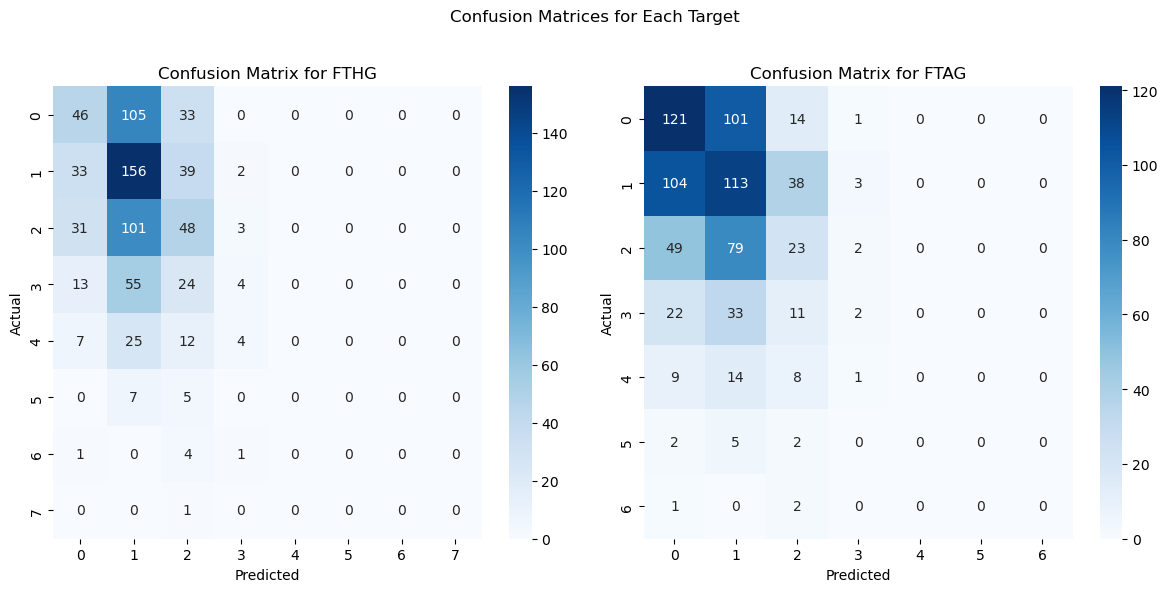

{'FTHG': 0.33421052631578946, 'FTAG': 0.34078947368421053}

In [40]:
# Initialize the RandomForestClassifier and wrap it with MultiOutputClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
multi_output_rf_model = MultiOutputClassifier(rf_model)

evaluate_classification_model(multi_output_rf_model, X_train, X_test, y_train, y_test, target_names=['FTHG', 'FTAG'])

### Baseline Model to compare
Median Predictor: Predict the median value of the target variable instead of the mean. This can be more robust to outliers and is also discrete

In [152]:
median_fthg = y_train['FTHG'].median()
median_ftag = y_train['FTAG'].median()

y_pred_baseline = pd.DataFrame({
    'FTHG': [median_fthg] * len(y_test),
    'FTAG': [median_ftag] * len(y_test)
})

mae_baseline_fthg = mean_absolute_error(y_test['FTHG'], y_pred_baseline['FTHG'])
mae_baseline_ftag = mean_absolute_error(y_test['FTAG'], y_pred_baseline['FTAG'])

print(f"Baseline MAE FTHG: {mae_baseline_fthg}")
print(f"Baseline MAE FTAG: {mae_baseline_ftag}")

Baseline MAE FTHG: 1.0355263157894736
Baseline MAE FTAG: 0.8855263157894737


Classification Report for FTHG:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       184
           1       0.30      1.00      0.46       230
           2       1.00      0.00      0.00       183
           3       1.00      0.00      0.00        96
           4       1.00      0.00      0.00        48
           5       1.00      0.00      0.00        12
           6       1.00      0.00      0.00         7

    accuracy                           0.30       760
   macro avg       0.90      0.14      0.07       760
weighted avg       0.79      0.30      0.14       760

Accuracy for FTHG: 0.3026315789473684

Classification Report for FTAG:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       237
           1       0.34      1.00      0.51       258
           2       1.00      0.00      0.00       153
           3       1.00      0.00      0.00        68
           4       1.00      

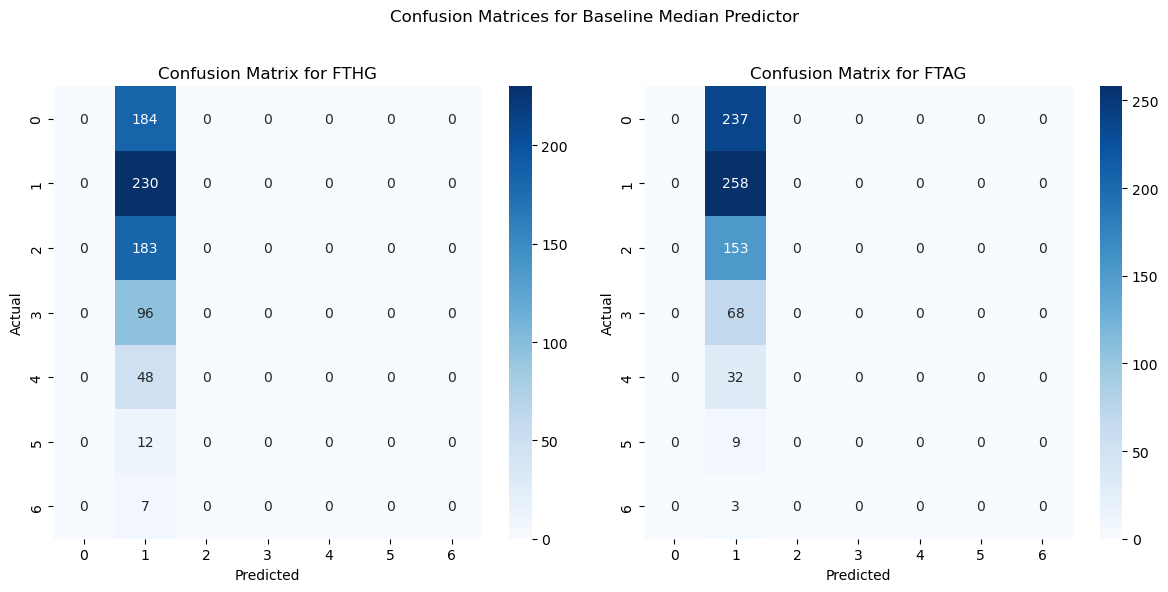

{'FTHG': 0.3026315789473684, 'FTAG': 0.3394736842105263}

In [153]:
def compute_result(df):
    """
    Compute the match result based on FTHG and FTAG.

    Parameters:
    - df: DataFrame containing 'FTHG' and 'FTAG' columns.

    Returns:
    - DataFrame with a new 'Result' column.
    """
    conditions = [
        (df['FTHG'] > df['FTAG']),
        (df['FTHG'] == df['FTAG']),
        (df['FTHG'] < df['FTAG'])
    ]
    choices = ['Home Win', 'Draw', 'Away Win']
    df['Result'] = pd.Categorical.from_codes(
        [choices.index(next(choice for i, choice in enumerate(choices) if condition[i])) for condition in zip(*conditions)],
        categories=choices
    )
    return df

def convert_to_discrete(y, bins):
    """
    Convert continuous values to discrete classes based on bins.

    Parameters:
    - y: Continuous values (e.g., predicted FTHG or FTAG).
    - bins: List of bin edges defining the discrete classes.

    Returns:
    - Discrete class labels based on the bin edges.
    """
    return np.digitize(y, bins=bins) - 1

def evaluate_median_predictor(X_train, X_test, y_train, y_test, target_names=['FTHG', 'FTAG'], bins=[0, 1, 2, 3, 4, 5, 6]):
    """
    Evaluate the performance of the median predictor as a baseline model.

    Parameters:
    - X_train: Training feature data.
    - X_test: Test feature data.
    - y_train: Training target data (multi-output).
    - y_test: Test target data (multi-output).
    - target_names: List of target variable names (e.g., ['FTHG', 'FTAG']).
    - bins: List of bin edges to convert continuous values to discrete classes.

    Returns:
    - Metrics: Dictionary containing accuracy scores for each target.
    """
    # Compute median values for the training targets
    median_fthg = y_train['FTHG'].median()
    median_ftag = y_train['FTAG'].median()

    # Predict the median value for all test instances
    y_pred_baseline = pd.DataFrame({
        'FTHG': [median_fthg] * len(X_test),
        'FTAG': [median_ftag] * len(X_test)
    })

    # Convert predictions and ground truth to discrete classes
    y_test_discrete = pd.DataFrame({
        'FTHG': convert_to_discrete(y_test['FTHG'], bins),
        'FTAG': convert_to_discrete(y_test['FTAG'], bins)
    })
    
    y_pred_discrete = pd.DataFrame({
        'FTHG': convert_to_discrete(y_pred_baseline['FTHG'], bins),
        'FTAG': convert_to_discrete(y_pred_baseline['FTAG'], bins)
    })
    
    # Initialize metrics dictionary
    metrics = {}

    # Set up the figure for confusion matrices
    num_targets = len(target_names)
    fig, axes = plt.subplots(1, num_targets, figsize=(num_targets * 6, 6))
    fig.suptitle('Confusion Matrices for Baseline Median Predictor')

    for i, target_name in enumerate(target_names):
        print(f"Classification Report for {target_name}:")
        print(classification_report(y_test_discrete[target_name], y_pred_discrete[target_name], zero_division=1))

        # Calculate accuracy for each target
        accuracy = accuracy_score(y_test_discrete[target_name], y_pred_discrete[target_name])
        metrics[target_name] = accuracy
        print(f"Accuracy for {target_name}: {accuracy}\n")

        # Confusion Matrix
        conf_matrix = confusion_matrix(y_test_discrete[target_name], y_pred_discrete[target_name])
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[i])
        axes[i].set_title(f"Confusion Matrix for {target_name}")
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust space to accommodate suptitle
    plt.show()

    return metrics

evaluate_median_predictor(X_train, X_test, y_train, y_test, target_names=['FTHG', 'FTAG'], bins=[0, 1, 2, 3, 4, 5, 6])

### Neural Networks

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Define the neural network model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1])
])

# Compile the model
nn_model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model
nn_model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=1)

# Make predictions
y_pred_nn = nn_model.predict(X_test)

# Evaluate the model
mae_nn = mean_absolute_error(y_test, y_pred_nn, multioutput='uniform_average')
r2_nn = r2_score(y_test, y_pred_nn, multioutput='uniform_average')

print("Neural Network Mean Absolute Error (MAE):", mae_nn)
print("Neural Network R-squared (R2):", r2_nn)


Epoch 1/100


/Users/loughlindavidson/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step - loss: 1.7054 
Epoch 2/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 1.5482
Epoch 3/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 1.4888
Epoch 4/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step - loss: 1.4134
Epoch 5/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step - loss: 1.4200
Epoch 6/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step - loss: 1.4072
Epoch 7/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 1.4268
Epoch 8/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - loss: 1.4005
Epoch 9/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step - loss: 1.4702
Epoch 10/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step - loss: 1.4480
Epoch 11/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step - loss: 1.4385
Epoch 12/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step - loss: 1.4198
Epoch 13/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 1.4152
Epoch 14/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step - loss: 1.3633
Epoch 15/100
304/304 ━━━━━

#### Dixon-Coles Model

In [71]:
from scipy.optimize import minimize
from scipy.stats import poisson

# Function to calculate the Poisson PMF
def poisson_pmf(home_goals, lambda_H, away_goals, lambda_A, theta):
    prob_home = poisson.pmf(home_goals, lambda_H)
    prob_away = poisson.pmf(away_goals, lambda_A)
    # Add the correlation adjustment
    return prob_home * prob_away * np.exp(theta * min(home_goals, away_goals))

# Define Poisson likelihood with correlation adjustment
def dixon_coles_likelihood(params, data):
    lambda_H, lambda_A, theta = params
    # Compute the negative log-likelihood for the Dixon-Coles model
    log_likelihood = 0
    for index, row in data.iterrows():
        h = row['FTHG']
        a = row['FTAG']
        # Add log of Poisson PMF adjusted for correlation
        log_likelihood += np.log(poisson_pmf(h, lambda_H, a, lambda_A, theta))
    return -log_likelihood
        
def dixon_coles_fit(data):
    initial_params = [1.0, 1.0, 0.0]  # Initial guesses for lambda_H, lambda_A, theta
    result = minimize(dixon_coles_likelihood, initial_params, args=(data,), method='Nelder-Mead')
    return result.x

# params = dixon_coles_fit(df)
# print("Fitted Parameters:", params)